
# Ungraded Lab: First DCGAN

In this lab, you will see a demo of a Deep Convolutional GAN (DCGAN) trained on Fashion MNIST. You'll see architectural differences from the GAN in the first lab and also see the best practices when building this network.

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/4-Generative-deeplearning-with-tensorflow/week-4/C4_W4_Lab_2_First_DCGAN.ipynb


In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, Dense, LeakyReLU,
                                     Reshape, BatchNormalization, Conv2D,
                                     Flatten)

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
def plot_results(images, n_cols=None, title=""):
  display.clear_output(wait=False)
  n_cols = n_cols or len(images)
  n_rows = (len(images) -1) // n_cols + 1

  if images.shape[-1] == 1:
    images = np.squeeze(images, axis = -1)
  plt.figure(figsize=(n_cols, n_rows))
  plt.figure(facecolor='w')
  for idx, image in enumerate(images):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(image, cmap='binary')
    plt.axis("off")
  if title:
    plt.savefig(f"./gan_FashionMNIST_generated/{title}", edgecolor=None)


In [3]:
# download the training images
(X_train, _), _ = keras.datasets.fashion_mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

# reshape and rescale
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
X_train.shape

(60000, 28, 28, 1)


# Build the Model

In DCGANs, convolutional layers are predominantly used to build the generator and discriminator. You will see how the layers are stacked as well as the best practices shown below.
# Generator

For the generator, we take in random noise and eventually transform it to the shape of the Fashion MNIST images. The general steps are:

  - Feed the input noise to a dense layer.
  - Reshape the output to have three dimensions. This stands for the (length, width, number of filters).
  - Perform a deconvolution (with Conv2DTranspose), reducing the number of filters by half and using a stride of 2.
  - The final layer upsamples the features to the size of the training images. In this case 28 x 28 x 1.

Notice that batch normalization is performed except for the final deconvolution layer. As best practice, selu is the activation used for the intermediate deconvolution while tanh is for the output. We printed the model summary so you can see the shapes at each layer.


In [5]:
codings_size = 32
ins = keras.layers.Input(shape=[codings_size])
x = Dense(7 * 7 * 128)(ins)
x = Reshape([7, 7, 128])(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, kernel_size=5, strides=2,
                    padding="same", activation='selu')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                      activation="tanh")(x)
generator = Model(ins, x, name='generator')
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 6272)              206976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       25

shape of the generated batch: (16, 28, 28, 1)


<Figure size 288x288 with 0 Axes>

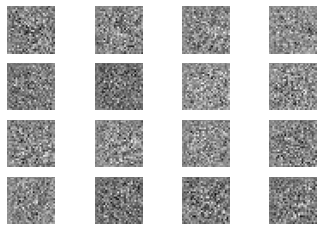

In [6]:
# 16 is just a batch size
test_noise = tf.random.normal([16, codings_size])
test_image = generator(test_noise)
plot_results(test_image, n_cols=4)
print(f'shape of the generated batch: {test_image.shape}')


# Discriminator

The discriminator will use strided convolutions to reduce the dimensionality of the input images. As best practice, these are activated by LeakyRELU. The output features will be flattened and fed to a 1-unit dense layer activated by sigmoid.


In [7]:
ins = keras.layers.Input([28, 28, 1])
x = Conv2D(64, kernel_size=5, strides=2, padding='same',
           activation=LeakyReLU(0.2))(ins)
x = keras.layers.Dropout(0.4)(x)
x = Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=LeakyReLU(0.2))(x)
x = keras.layers.Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(ins, x, name='descriminator')
discriminator.summary()


Model: "descriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)               

In [8]:
gan = keras.models.Sequential([generator, discriminator])



discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="adam")



In [9]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
      t = "Epoch %d"% (epoch+1)
      print(t)
      for real_imgs in dataset:
        batch_size = real_imgs.shape[0]

        ### Phase 1, train discriminator
        noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
        fake_images = generator(noise)

        # create a list by concatenating the real and fake images
        mixed_images = tf.concat([fake_images, real_imgs], axis=0)
        # discriminator labels are 0 for fake and 1 for real image
        discriminator_labels = tf.constant([[0.]]* batch_size + [[1.]]* batch_size)
        discriminator.trainable=True
        discriminator.train_on_batch(mixed_images, discriminator_labels)

        ### Phase 2 train the generator
        noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
        discriminator.trainable=False # freeze the discriminator
        # label all generated images to be "real"
        generator_labels = tf.constant([[1.]] * batch_size)
        # Train the GAN on the noise with the labels all set to be true
        gan.train_on_batch(noise, generator_labels)
      # plot the fake images used to train the discriminator
      plot_results(fake_images, 13, title=t)                     
      plt.show()


<Figure size 936x720 with 0 Axes>

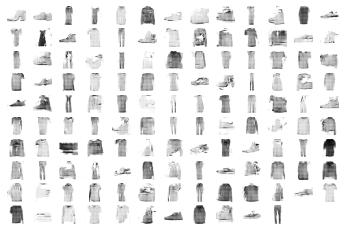

Epoch 38


In [ ]:
train_gan(gan, dataset, codings_size, 100)